## NH3 satellite plotting script

Satellite data is taken from the ESPRI data centre: http://espri.aeris-data.fr/etherTypo/index.php?id=1730&L=1



In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib import ticker

import xarray as xr
import numpy as np
import pandas as pd
from scipy.interpolate import griddata


In [2]:
# loads column and lat/lon data, and converts to panda array
def load_create_dataframe(xdata):

    column_data = xdata.column.copy(deep=True)
    lat_data = xdata.latitude.copy(deep=True)
    lon_data = xdata.longitude.copy(deep=True)
    
    #column_data.fillna(0)
    #column_data.where(column_data<0,0)

    # convert from xarray to pandas dataframe
    cd = column_data.to_dataframe()
    latd = lat_data.to_dataframe()
    lond = lon_data.to_dataframe()
    result = pd.concat([cd,latd,lond], axis=1, sort=False)

    return result

In [3]:
# groups column data into defined lat/lon bins, takes mean value for each bin, 
#                                and returns the 2D data array of these means
def grid_satellite_data(dataframe):
    
    # create the edge values for our lat/lon bins
    lat_bins = np.arange(-90,95,5)
    lon_bins = np.arange(-180,185,5)
    
    # drop NaN values, and then group into the lat/long bins
    resn = dataframe.dropna()
    grs = dataframe.groupby([pd.cut(dataframe.latitude,lat_bins),pd.cut(dataframe.longitude,lon_bins)])
    
    # get mean and count values, and reset the indexes for our dataset 
    #     - the longitude and latitude bins will now be column data rather than indexes
    grmean  = grs.column.mean().reset_index()
    grcount = grs.column.count().reset_index()

    
    # determine the grid centre locations from the grid information for the dataset
    grmean['Mid_Lon'] = grmean['longitude'].apply(lambda x: x.mid)
    grmean['Mid_Lat'] = grmean['latitude'].apply(lambda x: x.mid)

    # create 2D mesh for storing extracted data 
    lat_mid = np.arange(-87.5,92.5,5)
    lon_mid = np.arange(-177.5,187.5,5)
    lon_grid, lat_grid = np.meshgrid(lon_mid,lat_mid)
    
    # grid the model data (and counts)
    col_grid = griddata((grmean.Mid_Lon,grmean.Mid_Lat),grmean.column,(lon_grid,lat_grid))
    count_grid = griddata((grmean.Mid_Lon,grmean.Mid_Lat),grcount.column,(lon_grid,lat_grid))
    
    return col_grid, lon_grid, lat_grid, count_grid


### Loading satellite data

Modify the path information, to match the path to your data files. You will also need to correct the file name information, for selecting the files you want to process.

In [5]:
file_path = '/Volumes/Work_Space/Clearflo/satellite_data/'
#datadask = xr.open_mfdataset('nh3nn_v2_2_20120[12]*nc')
datadask = xr.open_mfdataset(file_path+'nh3nn_v2_2_20120[78]*nc')

#### Processing model data

Here the satellite data is based to the functions loaded above, to create the 2D map of satellite data 

In [6]:
test_data = load_create_dataframe(datadask)
test_grid, lon_grid, lat_grid, test_count = grid_satellite_data(test_data)

/Users/lowe/anaconda2/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


#### Plotting Information

In [7]:
Jet = plt.get_cmap('jet')
print(Jet(1))

cNorm  = colors.Normalize(vmin=0, vmax=test_grid.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=Jet)

print(scalarMap.get_clim())
#col_scale = sdata.column / 1e17

#(1e15,2e15,5e15,1e16,2e16,5e16,1e17)



(0.0, 0.0, 0.517825311942959, 1.0)
(0.0, nan)


#### NH3 column plotting

/Users/lowe/anaconda2/envs/iris/lib/python3.6/site-packages/matplotlib/contour.py:1483: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/Users/lowe/anaconda2/envs/iris/lib/python3.6/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


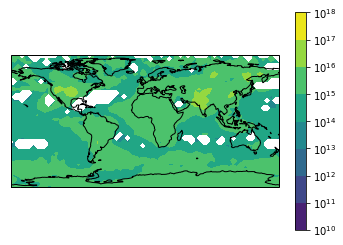

In [12]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#plt.contourf(lon_grid,lat_grid,test_grid,locator=ticker.LogLocator(),vmin=1e14,vmax=1e17)
#plt.contourf(lon_grid,lat_grid,test_grid,locator=ticker.LogLocator(subs=(1.,2.,5.))
plt.contourf(lon_grid,lat_grid,test_grid,locator=ticker.LogLocator())
plt.colorbar()

#### Data count plot

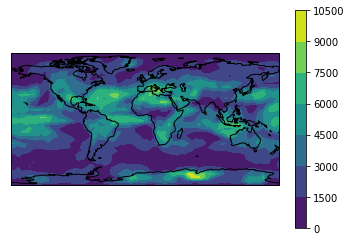

In [14]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(lon_grid,lat_grid,test_count)
plt.colorbar()

In [155]:
plt.contourf?